### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import h5py as h5
import sys
from scipy.stats import binned_statistic
from scipy.stats.mstats import theilslopes
from importlib import reload
from pathlib import Path

sys.path.append('/reg/neh/home4/espov/python/datastorage/')
import datastorage

import ana_fun as ana
import bokeh
from bokeh.io import output_notebook, show
from bokeh.plotting import figure

output_notebook()

#matplotlib.rcParams.keys()
matplotlib.rcParams['figure.figsize'] = (10, 7)
matplotlib.rc('font', size=14)
COLOR = 'grey'
matplotlib.rcParams['text.color'] = COLOR
matplotlib.rcParams['axes.labelcolor'] = COLOR
matplotlib.rcParams['xtick.color'] = COLOR
matplotlib.rcParams['ytick.color'] = COLOR
length = 8
width = 1.5
matplotlib.rcParams['xtick.major.size'] = length
matplotlib.rcParams['ytick.major.size'] = length
matplotlib.rcParams['xtick.major.width'] = width
matplotlib.rcParams['ytick.major.width'] = width

Loading BokehJS ...

### Load data

In [2]:
data = datastorage.read('vesp_run60_anaMPI.h5')
t0 = 51.75

mask = np.logical_and(~np.isnan(data.sig), ~np.isnan(data.I0))

dl = -(data.dl[mask]-t0)
I0 = data.I0[mask]*1000
I = data.sig[mask]
energy = data.ebeam.photon_energy[mask]
energyL3 = data.ebeam.L3_energy[mask]

dl.shape

(238155,)

### Apply energy correction

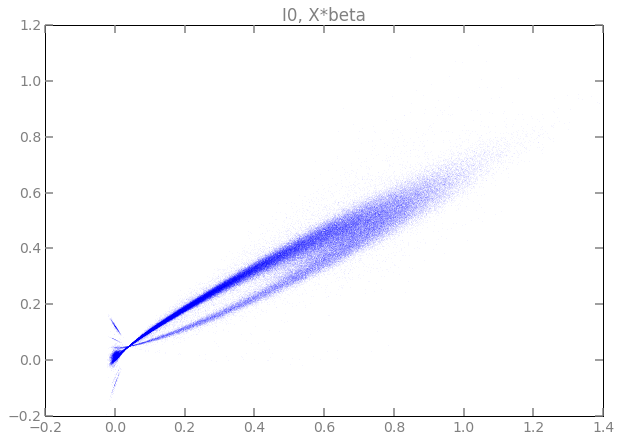

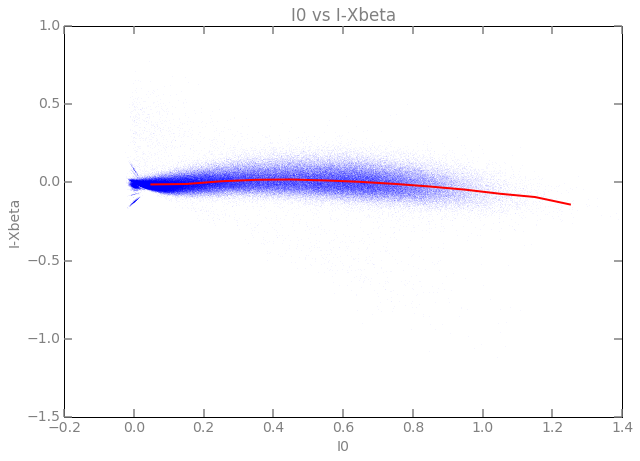

In [3]:
beta, Xbeta = ana.linearize_energy(I,I0,energy)
energy_I0_product = (energy-np.mean(energy))*(I0-np.mean(I0))
X = np.array([np.ones(len(I0)), I0, energy, energy_I0_product]).transpose()
Icorr = I - np.matmul(X[:,2:]-np.mean(X,axis=0)[2:], beta[2:])

plt.figure('I0, X*beta')
plt.title('I0, X*beta')
plt.plot(I0,Xbeta,'.',markersize=0.05)

plt.figure('I0 correlation corrected')
plt.plot(I0, I-Xbeta, '.', markersize=0.05)
plt.title('I0 vs I-Xbeta')
plt.xlabel('I0')
plt.ylabel('I-Xbeta')

bins = np.arange(0,1.4,0.1)
med = binned_statistic(I0, I-Xbeta, bins=bins, statistic='median').statistic
xmed = bins[:-1]+np.diff(bins)/2
plt.figure('I0 correlation corrected')
plt.plot(xmed, med, linewidth=2, color='red')
plt.show()

### Get rid of dl position with low counts

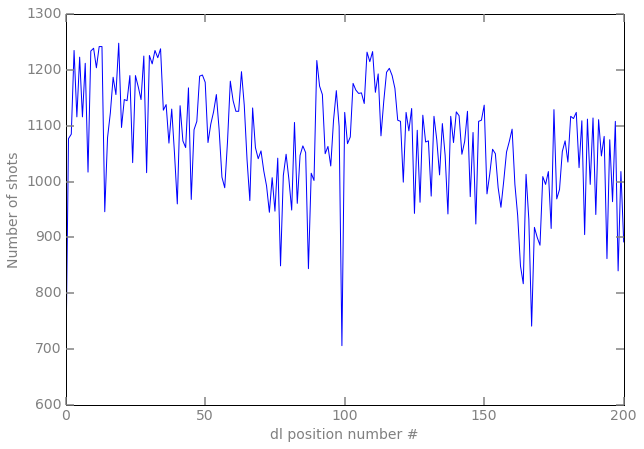

(215434,)

In [4]:
dl_mask = np.zeros(len(dl))
dl_un = np.unique(dl)
for t in dl_un:
    shots = np.sum(t==dl)
    if shots > 500:
        dl_mask = np.logical_or(dl_mask, (t==dl))
        
dl = dl[dl_mask]
I0 = I0[dl_mask]
I = I[dl_mask]
Icorr = Icorr[dl_mask]
energy = energy[dl_mask]
energyL3 = energyL3[dl_mask]

dl_un = np.unique(dl)
shots = []
for t in dl_un:
    shots.append(np.sum(dl==t))

shots = np.asarray(shots)
plt.figure()
plt.plot(shots)
plt.xlabel('dl position number #')
plt.ylabel('Number of shots')
plt.show()

dl.shape

## Plot I/I0 pump - probe

Numbers of shots before I0 filtering: (215434,)
Numbers of shots after I0 filtering: (152696,)


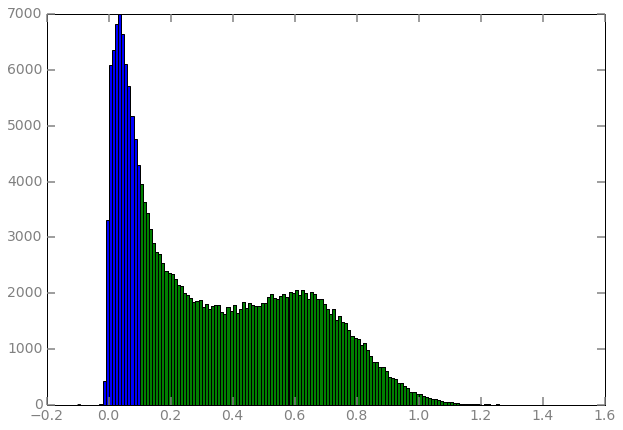

In [5]:
bins=np.arange(-0.1,1.5,0.01)
plt.hist(I0, bins=bins)
print('Numbers of shots before I0 filtering: {}'.format(I0.shape))

I0filt = 0.1
I0mask = I0>I0filt

dl = dl[I0mask]
I0 = I0[I0mask]
I = I[I0mask]
Icorr = Icorr[I0mask]
energy = energy[I0mask]
energyL3 = energyL3[I0mask]
print('Numbers of shots after I0 filtering: {}'.format(I0.shape))

plt.hist(I0, bins=bins)
plt.show()

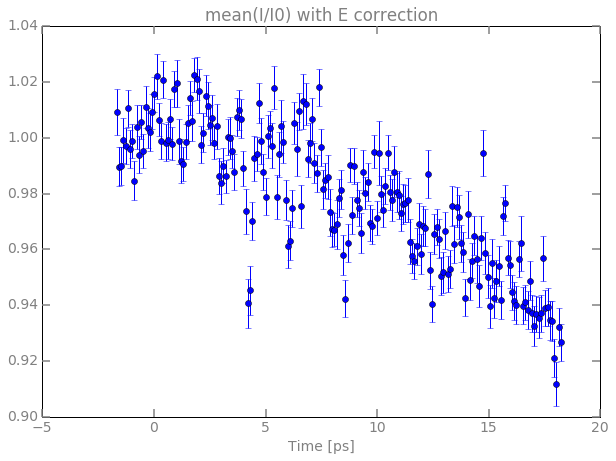

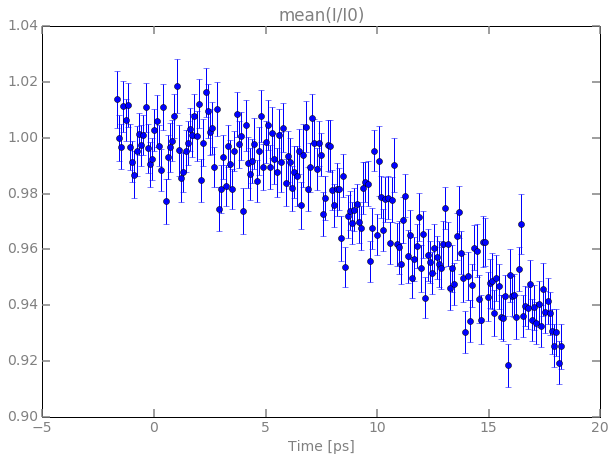

In [6]:
data_tobin = {
    'dl' : dl/0.15,
    'I0' : I0,
    'I' : I,
    'Inorm' : I/I0,
    'Icorr' : Icorr,
    'IcorrNorm' : Icorr/I0,
    'energy' : energy,
    'energyL3' : energyL3
}

binned_data, bin_edges = ana.binData(data_tobin, statkeys=['I0','I','Inorm','Icorr','IcorrNorm'])

to_plot = 'IcorrNorm'
plt.figure()
plt.errorbar(binned_data['dl'], 
             binned_data[to_plot+'_mean']/np.mean(binned_data[to_plot+'_mean'][binned_data['dl']<0]), 
             binned_data[to_plot+'_std']/np.sqrt(binned_data[to_plot+'_count']), marker='o', linestyle='None')
plt.xlabel('Time [ps]')
plt.title('mean(I/I0) with E correction')

to_plot = 'Inorm'
plt.figure()
plt.errorbar(binned_data['dl'], 
             binned_data[to_plot+'_mean']/np.mean(binned_data[to_plot+'_mean'][binned_data['dl']<0]), 
             binned_data[to_plot+'_std']/np.sqrt(binned_data[to_plot+'_count']), marker='o', linestyle='None')
plt.xlabel('Time [ps]')
plt.title('mean(I/I0)')
plt.show()